In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, Column, Integer, String, Float, text

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
#Inspector to check column types
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
print("-"*20)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
--------------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

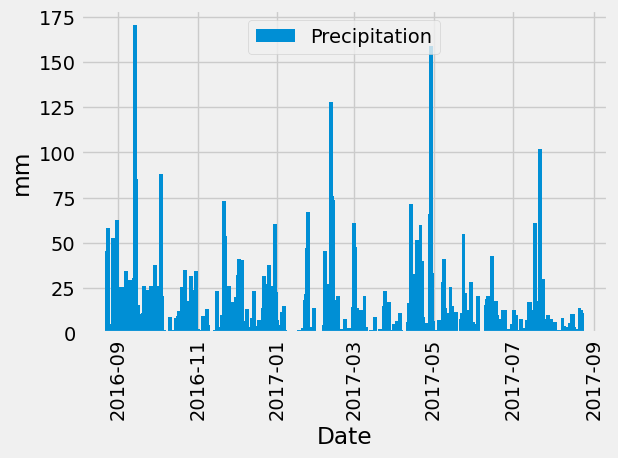

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date = dt.date(2017, 8, 23)

# Calculate the date one year from the last date in data set.
year_ago = recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
sel = [(Measurement.date), 
       (Measurement.prcp)]
data_to_plot = session.query(*sel).filter(Measurement.date >= year_ago)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(data_to_plot, columns=['Date', 'Precipitation'])
df.Date = pd.to_datetime(df.Date)

# Sort the dataframe by date
df_plot = df.dropna().sort_values(by='Date')
df_plot.set_index('Date', inplace=True)
df_plot

# Use Pandas Plotting with Matplotlib to plot the data
plt.bar(df_plot.index, df_plot["Precipitation"], width=3)
plt.xlabel("Date")
plt.ylabel("mm")
plt.grid(visible=True)
plt.xticks(rotation=90)
plt.legend(["Precipitation"], loc=9)
plt.tight_layout()
plt.show()


In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
count = df_plot["Precipitation"].count()

mean = df_plot["Precipitation"].mean()

std = df_plot["Precipitation"].std()

min = df_plot["Precipitation"].min()

quartiles = df_plot["Precipitation"].quantile([.25,.5,.75])
lowerq = quartiles[0.25]
midq = quartiles[0.5]
upperq = quartiles[0.75]

max = df_plot["Precipitation"].max()

# Creating dictionary
dictionary = [{"value": "count", "precipitation": count},
              {"value": "mean", "precipitation": mean},
              {"value": "min", "precipitation": min},
              {"value": "25%", "precipitation": lowerq},
              {"value": "50%", "precipitation": midq},
              {"value": "75%", "precipitation": upperq},
              {"value": "max", "precipitation": max}]

# Creating DataFrame
summary = pd.DataFrame(dictionary)
summary = summary.set_index("value")
summary.index.names = [""]
summary

,precipitation
,
count,2021.000000
mean,4.505888
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
query = session.query(Measurement).group_by(Measurement.station).all()
total_stations = len(query)
total_stations

9

In [15]:
engine.execute(text('SELECT * FROM Measurement LIMIT 5')).fetchall()

[(0, 'USC00519397', '2010-01-01', 2.0, 18.3),
 (1, 'USC00519397', '2010-01-02', 0.0, 17.2),
 (2, 'USC00519397', '2010-01-03', 0.0, 23.3),
 (3, 'USC00519397', '2010-01-04', 0.0, 24.4),
 (4, 'USC00519397', '2010-01-06', None, 22.8)]

In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
query = session.query(Measurement.station, func.count(Measurement.id)).\
    order_by(func.count(Measurement.id).desc()).\
    group_by(Measurement.station).all()

for row in query:
    print(row)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]
active_station = session.query(*sel).\
    filter(Measurement.station == query[0]["station"]).all()
active_station

[(12.2, 29.4, 22.03582251082252)]

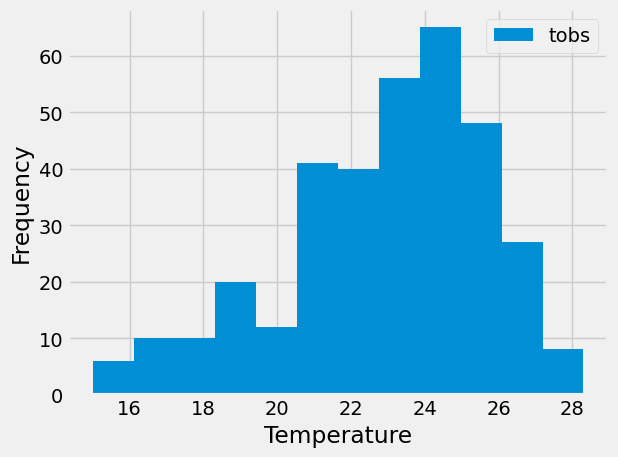

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Get the most recent date
newest_date = session.query(Measurement.date).filter(Measurement.station == query[0]["station"]).\
order_by(Measurement.date.desc()).first()

# Save value
newest_date = dt.date(2017, 9, 1)

# Calculate 1 year 
last_year = newest_date - dt.timedelta(days=365)

# Save it in a DataFrame
histogram = session.query(Measurement.tobs, Measurement.station).\
    filter(Measurement.station == query[0]["station"],\
           Measurement.date >= last_year, ).all()
histogram_df = pd.DataFrame(histogram)
histogram_df

# Generate histogram
histogram_df.plot.hist(bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


# Close Session

In [19]:
# Close Session
session.close()